# Advanced Lane Finding Project Demo

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

This demo show how the pipeline works, with test images firstly and then with project video.

---
## Calibrate camera using chessboard images

In [8]:
import glob
import importlib

import matplotlib.pyplot as plt

import pipeline


debug = True
save_test_image = True

importlib.reload(pipeline)
chessboard_img_files = glob.glob("data/camera_cal/*.jpg")
chessboard_rgb_images = [pipeline.load_image(f) for f in chessboard_img_files]
undistorter = pipeline.Undistorter(chessboard_rgb_images, (9,6))

if debug:
    print("camera matrix:\n", undistorter.camera_matrix)
    print("distortion coefficients:\n", undistorter.distort_coeffs)
    
if save_test_image:
    img = pipeline.load_image("data/camera_cal/calibration1.jpg")
    undistorted = undistorter.apply(img)
    pipeline.save_image("output_images/undistorted_calibration1.jpg", undistorted)

camera matrix:
 [[1.15777829e+03 0.00000000e+00 6.67113866e+02]
 [0.00000000e+00 1.15282230e+03 3.86124658e+02]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00]]
distortion coefficients:
 [[-0.24688572 -0.02372825 -0.00109832  0.00035104 -0.00260431]]


## Undistort images using calibrated values

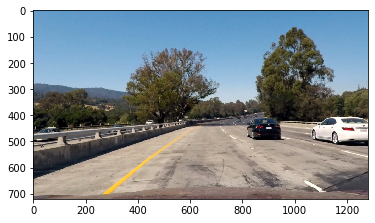

In [11]:
importlib.reload(pipeline)

raw_image_files = glob.glob("data/test_images/*.jpg")
rgb_raw_images = [pipeline.load_image(f) for f in raw_image_files]
rgb_undistorted_images = [undistorter.apply(rgb) for rgb in rgb_raw_images]

if debug:
    plt.imshow(rgb_undistorted_images[0])

if save_test_image:
    pipeline.save_image("output_images/undistorted_test.jpg", rgb_undistorted_images[0])

## Apply threshold to images

In [ ]:
importlib.reload(pipeline)

# PARAMS
extractor = pipeline.LaneFeatureExtractor(
        ksize_dict={
            'abs_sobel': 5,
            'mag_sobel': 5,
            'dir_sobel': 15,
        },
        thresh_dict={
            'abs_sobel': (40,255),
            'mag_sobel': (40,255),
            'dir_sobel': (0.8,1.4),
            'satur': (120, 255),
        })

binary_images = [extractor.extract(rgb, debug=debug) for rgb in rgb_undistorted_images]

## Warp perspective into birdview

In [ ]:
importlib.reload(pipeline)

height, width = binary_images[0].shape
warper = pipeline.Warper(
        width=width,
        upper_left_point_pair=[
            [526, 470], [300, 200]
        ],
        lower_left_point_pair=[
            [0, height-1], [300, height-1]
        ])

warped_binary_images = [warper.forward_warp(img, debug=debug) for img in binary_images]

## Detect lane and embed lane info on image

In [ ]:
importlib.reload(pipeline)

detector = pipeline.LaneDetector(
        n_windows=9,
        win_margin=60,
        reposition_thresh_rate=(0.02, 0.8),
        x_m_per_px=3.7/500,
        y_m_per_px=25/700,
        x_ignore_area=300,
        )
result_images = [detector.draw_lane(bin_img, raw_img, warper, debug=debug) for bin_img, raw_img in zip(warped_binary_images, rgb_undistorted_images)]

## Apply to the project video

In [ ]:
import numpy as np
importlib.reload(pipeline)

# Construct pipeline for stream processing
# using undistorer, extractor, warper, detector
def process_stream_image(raw_image):
    undistorted = undistorter.apply(raw_image)
    binary = extractor.extract(undistorted)
    warped_binary = warper.forward_warp(binary)
    embedded = detector.draw_lane(warped_binary, undistorted, warper, stream=True)
    return embedded

In [ ]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

input_video_file = "data/videos/project_video.mp4"
output_video_file = "output_videos/project_video.mp4"

In [ ]:
# Stream processing
in_clip = VideoFileClip(input_video_file)
out_clip = in_clip.fl_image(process_stream_image)
%time out_clip.write_videofile(output_video_file, audio=False)

In [ ]:
HTML("""
<video width="{width}" height="{height}" controls>
  <source src="{file}">
</video>
""".format(file=output_video_file, width=480, height=270))